# Final Project - Facial Keypoints Detection

Group: Ernesto Oropeza and Michael Hubert

Kaggle Project: Facial Keypoints Detection

## Introduction 

### Problem Statement
The goal of this project is to accurately predict the x and y coordinates for several facial features based on the image of a person's face. These features include multiple coordinates for the eye, mouth, eyebrow, and nose. Successfully predicting these coordinates with little error is the basis for tracking faces and facial recognition technologies. We will build, train, and test a model to predict these features with the lowest Root Mean Square Error (RMSE) possible. Our goal is to develop a model that will have an RMSE that is in the top 100 for Kaggle Competition leaderboard.

### Model Overview
The model we will use for the predicting the facial features is a Convolutional Neural Network (CNN). CNNs have proven to be very successful at identifying patterns in images and deliver state of the art performance. In addition to identifying which types of layers (2D convolutional, dense, etc.) we will need in the network, we will need to determine the number of layers as well as the number of neurons and activation function for each layer. Moreover, for the convolutional layers we need to evaluate the size of our filters and understand if zero padding will be needed to maintain the dimensions of the input image throughout the network.

The key parameter for the model will be the weights for each neuron connection of the network which we will optimize using an optimization algorithm similar to stochastic gradient descent to minimize our root mean squared error loss function. We will fit the model using training data and test the model's performance on unseen data.  Based on the model's performance on training and test data we then determine if we need to increase the model's complexity. We will also conduct error analysis after each model we build and review our worst predictions and our loss function for specific features to identify ways to improve our model.   

We will then improve the model by tuning hyperparameters such as the number of neurons for each layer in the CNN and explore techniques such as Max Pooling and Dropout to prevent our model from overfitting and improve the model's ability to generalize to the test data. We will then update the model, refit the model, and test the model again on our test data.  One of the challenges we will encounter during this project is building a CNN with missing data.  We will explore using a model with a masked loss function to allow us to train the model using all of the training dataset. At the end our analysis we then compare the performance across all of our models and also discuss additional feature engineering or data augmentation techniques that could be explored to improve the performance of future models. 



## Packages Used

In addition to using pandas, numpy, and matplotlib, we primarily used Keras to build our Convolutional Neural Network.  Keras is neural network library that runs on top of TensorFlow.   

In [1]:
#Import Packages
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import json
import os.path as fl
import os
import urllib.request as urllib2

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

#Import keras packages 
from keras.layers import Conv2D, MaxPooling2D,Layer
from keras.optimizers import *
from keras.metrics import *
from keras.losses import *
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D 
from keras.layers import BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D,Multiply
from keras import backend as K
from sklearn.utils import shuffle
from tensorflow import keras

## File System

### Data

The original data is downloaded from Kaggle under the following link:\
https://www.kaggle.com/c/facial-keypoints-detection/data?select=training.zip. \
The name of the file is ***training.zip*** for the Kaggle's competition. Otherwise, it also can be downloaded from our drive in the following link:\
https://drive.google.com/drive/folders/176D4a34yfzZvf7ETIx9ST2oih2l6XZCy?usp=sharing. \
Please be sure that the data (***training.csv***) have the following path form the location of this notebook: \
***/data/training/training.csv***


### Models and Loss 

After running the notebook for the first time, the CNN models are saved in a folder named ***models*** with three subfolders that correspond to each model. The following paths are from the location of this notebook: 
* /models/model_base 
* /models/model_base_extended
* /models/model_Mask

The loss and validation loss calculated during the training phase are also saved in the following files with JSON format: 
* models/model_base_loss.json
* models/model_base_extended_loss.json
* models/model_mask.json

***IMORTANT***: If any model is going to be trained, the corresponding model's folder must be removed from its location. Otherwise, it is going to be loaded from that location.

## Exploratory Data Analysis

After reviewing the initial training dataset we encountered several interesting features that will need to be address when building our CNN.  The first challenge we noticed was that not all of the coordinates for the facial features are available for all the images.  If an image had all the features, there would be 15 pairs of x and y coordinates. When we ran summary statistics for the training dataset we noticed many of the features were available for roughly 2,000 of the images when the entire dataset included over 7,000 images.  We are going to start with building a model with just the images that have all the features but will likely need to shift to a model that uses all the images to ensure we can generalize well to the final test data. During our exploratory data analysis, we did notice the pixels for the images were stored in one column as a long string.  We converted each pixel in the string to integer values in separate columns that we then could use to visualize the data.  The pixel grayscale values ranged from 0 to 255 and the coordinate values ranged from approximately 0 to 96 consistent with the shape of the images which is 96 by 96.  

We plotted several of the images with their respective facial feature coordinates to understand the dimensions and resolution of the images.  The images appeared to be fairly high resolution and when we plotted an image that did not have all the coordinates, we noticed the person was wearing glasses something we will likely encounter with many images. 


### Loading Data

In [2]:
filepath = os.getcwd()

In [3]:
all_data_raw = pd.read_csv(filepath + "\\data\\training\\training.csv")

In [4]:
#Review format of x and y cordinate features
all_data_raw.iloc[:,:30].head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774


In [5]:
# Split training data into input and output dataframes
x_all_data = all_data_raw.iloc[:,30]
y_all_data = all_data_raw.iloc[:,:30]

In [6]:
#Split str of inputs into seperate columns for each pixel
x_all_data_split = all_data_raw.iloc[:,30].str.split(pat=" ", expand = True)

In [7]:
#Convert pixel values to numeric
x_all_data_split = x_all_data_split.apply(pd.to_numeric)

In [8]:
#Review summary metrics for pixels
x_all_data_split.describe()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
count,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,...,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000,7049.000000
mean,108.515534,105.775004,102.436516,99.514967,96.469003,93.459498,90.831749,88.607320,86.930487,85.467584,...,105.375372,106.110654,106.564619,107.017733,107.786069,108.795999,109.627607,110.425876,111.107675,111.317350
std,73.884031,72.636260,71.477313,70.137930,68.483978,67.140833,65.909954,64.784854,63.776457,62.817623,...,72.211138,72.761269,73.205149,73.695312,74.123051,74.592851,74.919131,75.349426,75.883653,76.282723
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,41.000000,40.000000,38.000000,37.000000,36.000000,36.000000,35.000000,35.000000,...,43.000000,44.000000,43.000000,44.000000,44.000000,45.000000,44.000000,45.000000,45.000000,44.000000
50%,95.000000,91.000000,87.000000,83.000000,81.000000,77.000000,74.000000,72.000000,70.000000,69.000000,...,95.000000,96.000000,96.000000,96.000000,97.000000,98.000000,99.000000,100.000000,101.000000,101.000000
75%,168.000000,163.000000,159.000000,153.000000,147.000000,140.000000,136.000000,131.000000,129.000000,127.000000,...,155.000000,157.000000,158.000000,159.000000,160.000000,163.000000,165.000000,167.000000,170.000000,170.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [9]:
#Review summary metrics for cordinates 
y_all_data.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


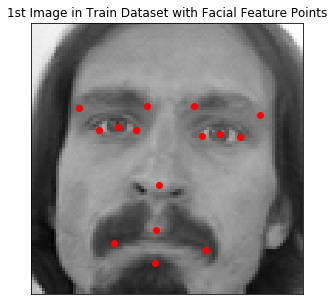

In [10]:
#Plot sample image with cordinates 
index_numpy = np.array(x_all_data_split)
plt.figure(figsize=(5,5))
plt.subplots_adjust(hspace=.5)
plt.subplot(1,1,1)   
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title("1st Image in Train Dataset with Facial Feature Points")

plt.imshow(np.reshape(index_numpy[0],(-1, 96)),interpolation='nearest', cmap='gray')
for i in range(0,30,2):
  plt.scatter(y_all_data.iloc[0,i], y_all_data.iloc[0,i+1], c='r')  
plt.show()

## Update with title for images saying what it is

In [11]:
#Find examples of images without left_eye_inner_corner_x cordinate 
y_all_data[y_all_data.left_eye_inner_corner_x.isnull()].head(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
1654,66.983855,37.191636,30.778167,27.431834,NaN,NaN,76.579801,40.116137,38.349460,30.472663,...,47.356172,54.676425,60.910345,70.723153,18.179873,60.403659,41.001999,67.490500,38.801970,73.222801
1685,65.153204,39.850963,30.073522,40.311816,NaN,NaN,72.418622,40.836359,NaN,NaN,...,48.408086,59.520387,66.747711,81.967816,32.127888,84.451582,50.412462,81.977636,49.874749,83.356986
1738,64.698292,41.840302,30.664127,39.857899,NaN,NaN,72.205593,42.196825,38.008889,40.258927,...,53.503350,55.656740,57.720067,82.036922,27.478519,80.292668,44.365134,79.399571,43.650491,81.742101
1742,59.419060,39.825120,32.745235,37.487248,NaN,NaN,NaN,NaN,37.991639,38.536529,...,37.872247,58.465766,57.688098,75.699000,36.233064,74.628681,44.034717,74.072115,44.519929,75.407095
1866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.427229,53.877310,57.458039,80.878314,32.511208,76.078956,45.435075,76.046196,44.288471,79.993791


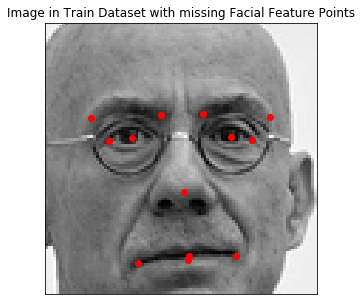

In [12]:
#Plot sample image without left_eye_inner_corner_x cordinate 
index_numpy = np.array(x_all_data_split)
plt.figure(figsize=(5,5))
plt.subplots_adjust(hspace=.5)
plt.subplot(1,1,1)   
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title("Image in Train Dataset with missing Facial Feature Points")
plt.imshow(np.reshape(index_numpy[1685],(-1, 96)),interpolation='nearest', cmap='gray')
for i in range(0,30,2):
  plt.scatter(y_all_data.iloc[1685,i], y_all_data.iloc[1685,i+1], c='r')  
plt.show()

### Number of Examples per Feature

> The images are not completely labeled for all the available data. Here we count the number of facial features that were labeled from the total number of examples. Note that the only feature that is lableled in all examples is the nose tip (7,049 total examples). 



In [13]:
print('{:<30}|{:>20}'.format('Feature Coordinate', 'Number of Examples'))
print(51*'-')
for feature in list(all_data_raw.columns):
    print('{:<30}|{:>20}'.format(feature,len(all_data_raw[(all_data_raw[feature].notnull()) & 
                                                          (all_data_raw[feature].notnull())])))

Feature Coordinate            |  Number of Examples
---------------------------------------------------
left_eye_center_x             |                7039
left_eye_center_y             |                7039
right_eye_center_x            |                7036
right_eye_center_y            |                7036
left_eye_inner_corner_x       |                2271
left_eye_inner_corner_y       |                2271
left_eye_outer_corner_x       |                2267
left_eye_outer_corner_y       |                2267
right_eye_inner_corner_x      |                2268
right_eye_inner_corner_y      |                2268
right_eye_outer_corner_x      |                2268
right_eye_outer_corner_y      |                2268
left_eyebrow_inner_end_x      |                2270
left_eyebrow_inner_end_y      |                2270
left_eyebrow_outer_end_x      |                2225
left_eyebrow_outer_end_y      |                2225
right_eyebrow_inner_end_x     |                2270
right_eyebro

## Shuffle and Splitting Train and Test Data

The Kaggle challenge consist of train data and test data. However, the test data is not labeled and is meant to compare performance across models that are submitted for the competition. We use the Kaggle training data as our complete dataset and use a random shuffle and split 80% of the data into training data and 20% of the data for test/validation. The output is two data frames: **all_train_data_raw** and **all_test_data_raw** with the original format of the complete data. Hereafter, any subset of the data for training is going to be selected from **all_train_data_raw** and any test/validation or result demonstration is taken from **all_test_data_raw**. 


In [14]:
np.random.seed(0)

ptc= 80 #Percentage of training data
ptc*=0.01

all_data_raw_shuffle = all_data_raw.copy()
all_data_raw_shuffle = shuffle(all_data_raw_shuffle)
all_data_raw_shuffle = all_data_raw_shuffle.reset_index()
all_data_raw_shuffle = all_data_raw_shuffle.drop('index', axis=1)

numExamples = int(np.round(all_data_raw.shape[0]*ptc))

all_test_data_raw = all_data_raw_shuffle.loc[numExamples:]
all_test_data_raw = all_test_data_raw.reset_index()
all_test_data_raw = all_test_data_raw.drop('index', axis=1)

all_train_data_raw = all_data_raw_shuffle.loc[:numExamples]
all_train_data_raw = all_train_data_raw.reset_index()
all_train_data_raw = all_train_data_raw.drop('index', axis=1)

numTrainExamples = all_train_data_raw.shape[0]
numTestExamples = all_test_data_raw.shape[0]

print('Train set:  all_train_data_raw = ', numTrainExamples)
print('Test set: all_test_data_raw = ', numTestExamples)

Train set:  all_train_data_raw =  5640
Test set: all_test_data_raw =  1410


## Functions




This section gathers most of the functions used in this notebook for different proposes:
  * ***datanotnull***: extract the images with input(desired) features (e.g. right_eye_center)
  * ***data_prep***: transform the data frames to numpy arrays needed in Keras CNN
  * ***Normalization functions***: These functions to scale input variables to between 0 and 1 and cordinates to -1 and 1 includes functions to scale back the data to its original form.
  * ***Loss and Validation Loss***: These two functions (plot_loss_json and plot_loss_json) plot the loss and validation loss calculated at each epoch during the training phase.
  * ***plot_prediction***: plot the images to compare the true and predicted labels
  * ***error_df***: creates a data frame with errors between true and predicted labels
  


In [15]:
# datanotnull return a data frame with the examples and their corresponding labels 
# that have the specified keypoints features    

def datanotnull(df,features = []):
    # df: raw input data frame
    # features: desaired features
    dfo = df.copy()
    features_list = features.copy()
    for feature in features_list:
        dfo = dfo[dfo[feature].notnull()]
        
    features_list.append('Image') # To output the image as well
    return dfo[features_list]

In [16]:
# data_prep returns a pair (labels, images) in numpy format with the data type and 
# shape required by Keras CNN.

def data_prep(df):
    #df : input data frame (without nan's)
    
    #Image size
    imx = 96
    imy = 96
    
    data_labels = np.zeros((df.shape[0],df.shape[1]-1),dtype='float64')
    data_images = np.zeros((df.shape[0],imy*imx),dtype='float64')
    cid = 0
    for item in df:
        if (item == 'Image'): 
            for k in range(df.shape[0]):
                data_l = df.iloc[k]['Image'].split(' ')
                data_images[k,:] = np.array(data_l, dtype='float64')
        else:
            data_labels[:,cid] = df[item][:]#All Images
            cid+=1

    data_images = data_images.reshape(-1,imy,imx,1)

    return data_labels, data_images

In [17]:
# Data Normalization. Image 1-0 and Coordinates -1 to 1
def image_norm(data):
    return data/255

def label_norm(labels):
    return labels/48.0 - 1.0

def image_norm_back(data):
    return data*255

def label_norm_back(labels):
    return 48.0*(labels+1.0)

In [18]:
# This function plots the training loss values and the validation values from the history file output in Keras
def plot_loss(model_history):
    train_loss = np.array(model_history.history['loss'])
    valid_loss = np.array(model_history.history['val_loss'])
    plt.plot(train_loss, "--", linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("MSE-loss")
    #plt.ylim(10e1, 10e3)
    plt.yscale("log")
    plt.show()

# This function plots the training loss values and the validation values from a JSON file previously created
def plot_loss_json(model_loss):
    train_loss = np.array(model_loss['loss'])
    valid_loss = np.array(model_loss['val_loss'])
    plt.plot(train_loss, "--", linewidth=3, label="train")
    plt.plot(valid_loss, linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("MSE-loss")
    #plt.ylim(10e1, 10e3)
    plt.yscale("log")
    plt.show()

In [19]:
#Plot Function
def plot_prediction(x_data, y_label, y_prediction, index, ax = None):
    ax = ax or plt.gca()
    ax.imshow(x_data[index].reshape(96,96),interpolation='nearest', cmap='gray')
    for i in range(0,y_label.shape[1],2):
        ax.scatter(y_label[index,i], y_label[index,i+1], c='r')  
    for i in range(0,y_prediction.shape[1],2):
        ax.scatter(y_prediction[index,i],y_prediction[index,i+1], c='b')  

    return ax

In [20]:
# loss_to_json save the loss and validation output in history from keras to a JSON file
def loss_to_json(model_history,jsonfile):
    dict_out = {}
    dict_out['loss'] = model_history.history['loss']
    dict_out['val_loss'] = model_history.history['val_loss']
    json.dump(dict_out, open(jsonfile, 'w'))

In [21]:
# error_df calculate a data frame with the square error of the prediction
# The shape of the data frame is the (number of example x 15). 15 corresponds to each feature

def error_df(y_true,y_pred):
    col = 0
    sqe = np.empty((y_true.shape[0],15))
    for j in range(0,30,2):
        sqe[:,col] = (y_true[:,j]-y_pred[:,j])**2
        sqe[:,col] += (y_true[:,j+1]-y_pred[:,j+1])**2
        sqe[:,col] /= 2.0
        col +=1
    
    feature_list = list(all_data_raw.columns) # extracting columns form the original data frame
    feature_list.pop()                      # excluding the column Image
    feat_column = []
    for j in range(0,30,2):                 # This loop takes the unique feature name (whithout _x and _y)
        feature = feature_list[j]
        feature = feature[:-2]
        feat_column.append(feature)
        
    sqr_df = pd.DataFrame(data= sqe, columns= feat_column)
    return sqr_df 

# Model Building (Convolutional Neural Network)

## Base Model

For our base model we started with a simple CNN that included 1 convolutional layer with 32 neurons and a 3 by 3 filter to detect features in each image.   For our activation function we utilized a Rectified Linear activation function that has been become very popular when building CNN to avoid vanishing gradient problems which can occur when building models with many layers. 

In addition to our 2D convolutional layer we included a Max Pool layer that calculates the maximum value for the feature map in the prior layer reducing dimensionality and helping prevent the model from overfitting. We also utilized  batch normalization which we learn can help normalization information in the hidden layer and allows each layer to learn features more independently.  We then included a Flatten layer to convert the 2D matrix to a single array that could then be used by dense layers.  Before making our final prediction we included a large dense layer and used drop out which is a regularization method that randomly ignores nodes.  In the final dense layer we had 30 neurons to reflect each coordinate that needs to be predicted and utilized the default activation function for the dense layer which is a linear activation function to make the regression predictions. 

To fit our model we only used the 2,140 examples that have coordinates for all (15) features.  We split this data into train and test groups with approximately 80% of the data in the training set for the base model. Since our inference problem involved minimizing our root mean squared error we used a mean squared error loss function and selected Adam as our optimizer to update the weights in our CNN with a learning rate of .001.  Adam is a popular alternative to Stochastic Gradient Descent and has been widely adopted by practitioners because of its ability to obtain good performance fast.   

Before fitting our model we had to define two hyperparameters, the batch size and number of epochs for the network which is the number of times the CNN will use each image in the training set to update parameters.  We decided to use a batch size of 128 which involves updating the model parameters after 128 samples.  We explored using different number of epochs and felt comfortable using 100, which often was sufficient to realize good performance without running for too long, with an additional computation power we would have liked to explore running the model with more epochs.


### Data Selection

The train data used in this model correspond to all train examples that have all 15 features labeled. The number of examples were reduced to 2,140, approximately 1/3 of the original size of the dataset.

In [22]:
#Select data will all keypoint features

features = [
            'left_eye_center_x', 'left_eye_center_y', 
            'right_eye_center_x','right_eye_center_y', 
            'left_eye_inner_corner_x','left_eye_inner_corner_y',
            'left_eye_outer_corner_x','left_eye_outer_corner_y', 
            'right_eye_inner_corner_x','right_eye_inner_corner_y',
            'right_eye_outer_corner_x','right_eye_outer_corner_y', 
            'left_eyebrow_inner_end_x','left_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x','left_eyebrow_outer_end_y', 
            'right_eyebrow_inner_end_x','right_eyebrow_inner_end_y', 
            'right_eyebrow_outer_end_x','right_eyebrow_outer_end_y', 
            'nose_tip_x', 'nose_tip_y',
            'mouth_left_corner_x', 'mouth_left_corner_y', 
            'mouth_right_corner_x','mouth_right_corner_y', 
            'mouth_center_top_lip_x','mouth_center_top_lip_y', 
            'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y',
           ]

df_filtered = datanotnull(all_train_data_raw,features)
y_train_all_keypoints,x_train_all_keypoints = data_prep(df_filtered)

df_filtered = datanotnull(all_test_data_raw,features)
y_test_all_keypoints,x_test_all_keypoints = data_prep(df_filtered)

#Scaling Training Data
x_train_all_keypoints = image_norm(x_train_all_keypoints)
y_train_all_keypoints = label_norm(y_train_all_keypoints)

#Scaling Test Data
x_test_all_keypoints = image_norm(x_test_all_keypoints)
y_test_all_keypoints = label_norm(y_test_all_keypoints)

print('Train Data shape: ' ,x_train_all_keypoints.shape)
print('Train Labels  shape: ', y_train_all_keypoints.shape)
print('Test Data shape: ' ,x_test_all_keypoints.shape)
print('Test Labels  shape: ', y_test_all_keypoints.shape)

Train Data shape:  (1730, 96, 96, 1)
Train Labels  shape:  (1730, 30)
Test Data shape:  (410, 96, 96, 1)
Test Labels  shape:  (410, 30)


In [23]:
#Create base CNN and summarize layers and output shape
model_base = Sequential()

model_base.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model_base.add(ReLU())
model_base.add(MaxPool2D(pool_size=(2, 2)))
model_base.add(BatchNormalization())

model_base.add(Flatten())
model_base.add(Dense(512,activation='relu'))
model_base.add(Dropout(0.1))
model_base.add(Dense(30))

model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
re_lu (ReLU)                 (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               37749248  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

### Base Model Error Analysis

Once we fit our model and identified the connection weight parameters for the model, we then tested the model on the test dataset to see how the model generalized to unseen data.  When we reviewed the loss performance for the CNN, we did see both the training and test (also labeled as validation) improved with additional epochs. We then used our model to make prediction on the test dataset we outlined at the start of the project which included images with key points missing.  We reviewed the MSE loss for each image as well as each predicted feature and the best and worst performing predictions. As would be expected with fitting the model on only a subset of the data that had all keypoints available, we had large errors on many images and had poor performance on left and right center eyes, nose tip, and center bottom lip features. Those specific features are very common in larger dataset we excluded from our training dataset by only focusing only on the data with key points available. 

Our worst performing prediction had a very large error because our predicted coordinates were out of range, per the image below for the worst example the initial plot appears to show a blank image but after limiting the x and y coordinates to the size of the actual image, we saw the original image that had poor resolution. In future models, we will evaluate our performance on this image to see if we are able to make better predictions on images with poor resolution and avoid out of range predictions.  The RMSE for the base model on our entire test data was very high at 258.  This coupled with our poor performance even on the training data (RMSE 50) indicates we should continue to increase our models complexity and evaluate how we can increase the size of our training set.  In our extended base model, we will explore adding more layers to the model and understand the performance improvements from this increased complexity.




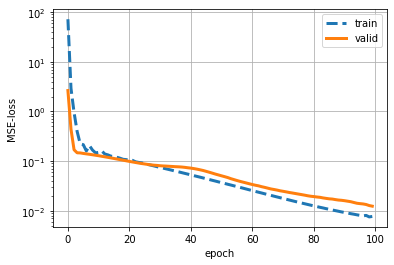

In [24]:
if fl.exists(filepath +'\\models\\model_base'):
    # Loading the model and the loss
    model_base = keras.models.load_model(filepath + '\\models\\model_base')
    model_base_loss = json.load(open(filepath + '\\models\\model_base_loss.json'))
    
    # Error Analysis Training Model
    plot_loss_json(model_base_loss)
    
else:    
    Batch = 128
    model_base.compile(optimizer=Adam(lr=.001), loss='mean_squared_error')
    model_base_loss = model_base.fit(x_train_all_keypoints,y_train_all_keypoints, batch_size=Batch, 
                                        validation_data=(x_test_all_keypoints,y_test_all_keypoints), 
                                        epochs=3,verbose=1)
    
    # Error Analysis Training Model
    plot_loss(model_base_loss)
    
    # Saving the model
    model_base.save(filepath + '\\models\\model_base')
    loss_to_json(model_base_loss,filepath + '\\models\\model_base_loss.json')    

In [25]:
# Test Error
# Preparing all test examples
y_all_test,x_all_test = data_prep(all_test_data_raw)
x_all_test = image_norm(x_all_test)

#Prediction with model trained with all features
y_test_pred_base = model_base.predict(x_all_test)
y_test_pred_base = label_norm_back(y_test_pred_base)

# Calculating Error DataFrame by Feature for each Test Example
sqe_df = error_df(y_all_test,y_test_pred_base)

# Mean Error per Feature
sqe_by_feature = sqe_df.mean(axis=0)

# Mean Error per Example
sqe_df['Mean_Error'] = sqe_df.mean(axis=1)

# Train Error
#Prediction with model trained with all features
y_train_pred_base = model_base.predict(x_train_all_keypoints)
y_train_pred_base = label_norm_back(y_train_pred_base)

# Calculating Error DataFrame by Feature for each Test Example
sqe_dft = error_df(y_train_all_keypoints,y_train_pred_base)

# Mean Error per Example
sqe_dft['Mean_Error'] = sqe_dft.mean(axis=1)

test_error = np.sqrt(sqe_df['Mean_Error'].mean())
train_error = np.sqrt(sqe_dft['Mean_Error'].mean())

print('Base Model - RMSE')
print('{:<8} {:<8}'.format('Train', 'Test'))
print('{:<8.2f} {:<8.2f}'.format(train_error,test_error))

Base Model - RMSE
Train    Test    
50.24    258.34  


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

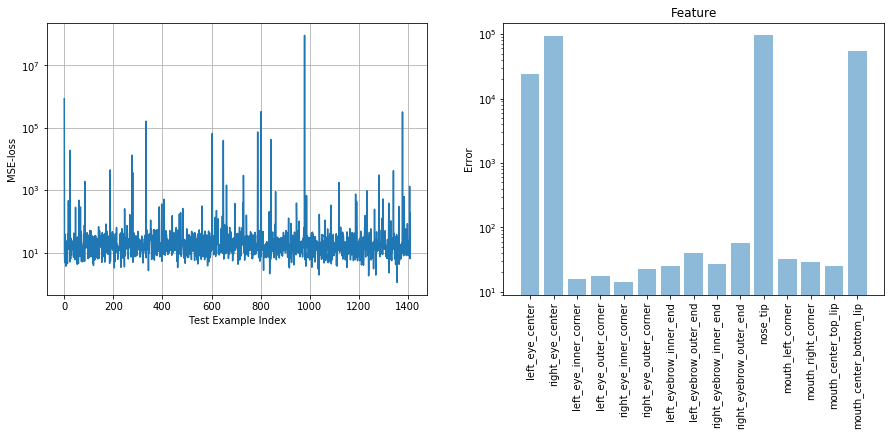

In [26]:
# Ploting Error on Test Data
plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=.25)
plt.subplot(1,2,1)   
plt.grid()
plt.plot(sqe_df['Mean_Error'])
plt.xlabel("Test Example Index")
plt.ylabel("MSE-loss")
plt.yscale("log")

# Ploting Error per feature
plt.subplot(1,2,2) 
plt.subplots_adjust(hspace=.75)
y_pos = np.arange(len(sqe_by_feature.index))
plt.bar(y_pos, sqe_by_feature, align='center', alpha=0.5)
plt.xticks(y_pos, sqe_by_feature.index)
plt.ylabel('Error')
plt.title('Feature')
plt.yscale("log")
plt.xticks(rotation=90)

Minimum Error Example:  1356    1.099367
Name: Mean_Error, dtype: float64


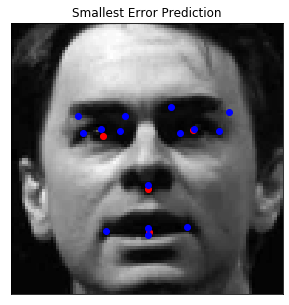

In [27]:
# Ploting Smallest Error Example
index =sqe_df[['Mean_Error']].idxmin()
print('Minimum Error Example: ',sqe_df['Mean_Error'][index])

fig, (ax1) = plt.subplots(1,figsize=(5,5))
plot_prediction(x_all_test,y_all_test,y_test_pred_base,index,ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_title('Smallest Error Prediction')
fig.show()

Maximum Error Example: 979    9.211544e+07
Name: Mean_Error, dtype: float64


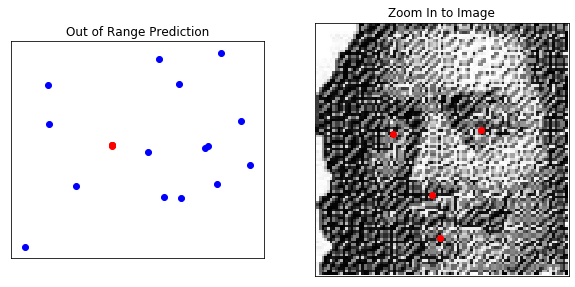

In [28]:
# Ploting Largest Error Example
index =sqe_df[['Mean_Error']].idxmax()
print('Maximum Error Example:',sqe_df['Mean_Error'][index])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
plot_prediction(x_all_test,y_all_test,y_test_pred_base,index,ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_title('Out of Range Prediction')

plot_prediction(x_all_test,y_all_test,y_test_pred_base,index,ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim([0,96])
ax2.set_ylim([96,0])
ax2.set_title('Zoom In to Image')

fig.show()

## Extended Base Model



In our extended base model we increased the model's complexity to improve the model's performance on training and test datasets.  At this stage, we continued to use the data for training that only has the all the keypoints.  We leveraged the primary structure from our base model but added multiple hidden convolutional layers with varying number of neurons including 32, 64, and 128 neurons. 

In [29]:
#Create new CNN model leveraging similar stucture as base model with added complexity
model_base_extended = Sequential()

model_base_extended.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model_base_extended.add(ReLU())
model_base_extended.add(MaxPool2D(pool_size=(2, 2)))
model_base_extended.add(BatchNormalization())

model_base_extended.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model_base_extended.add(ReLU())
model_base_extended.add(MaxPool2D(pool_size=(2, 2)))
model_base_extended.add(BatchNormalization())

model_base_extended.add(Convolution2D(128, (3,3), padding='same', use_bias=False))
model_base_extended.add(ReLU())
model_base_extended.add(MaxPool2D(pool_size=(2, 2)))
model_base_extended.add(BatchNormalization())

model_base_extended.add(Flatten())
model_base_extended.add(Dense(512,activation='relu'))
model_base_extended.add(Dropout(0.1))
model_base_extended.add(Dense(30))

model_base_extended.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)       

### Extended Base Model Error Analysis

The result of the model's increased complexity was an improvement our model's RMSE on the entire test data from 258 to 53.  Per the MSE loss for key features, we experienced a large reduction on the error for the left and right eye center points from our base model. However, even with the increased complexity in the model, our performance did not improve on the training data and our overall performance on test was still well below the Kaggle leaderboard which had RMSE in the 2 to 5 range. The sample level MSE chart below, shows that there are still several images with very high error and upon examining our worst prediction, we are still having difficulty making predictions for images that have poor resolution.  We had a marginal MSE improvement on the image 979 in the test data from 9.2e+07 to 3.6e+06. To accurately make predictions on these types of photos we need to make adjustments to the extend model to be able to train on the entire dataset will all images to improve the models performance on all the test data with and without all the keypoints labeled.  

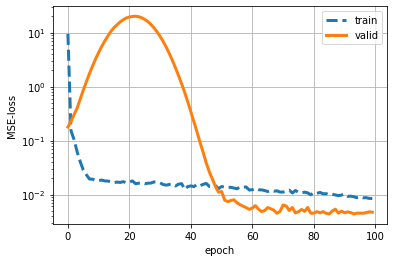

In [30]:
if fl.exists(filepath + '\\models\\model_base_extended'):
    # Loading the model and the loss
    model_base_extended = keras.models.load_model(filepath + '\\models\\model_base_extended')
    model_base_extended_loss = json.load(open(filepath + '\\models\\model_base_extended_loss.json'))
    
    # Ploting Error Analysis
    plot_loss_json(model_base_extended_loss)

else:
    Batch = 128
    model_base_extended.compile(optimizer=Adam(lr=.001), loss='mean_squared_error')
    model_base_extended_loss = model_base_extended.fit(x_train_all_keypoints,y_train_all_keypoints, batch_size=Batch, 
                                                          validation_data=(x_test_all_keypoints,y_test_all_keypoints), 
                                                          epochs=100,verbose=1)
    model_base_extended.save(filepath + '\\models\\model_base_extended')
    loss_to_json(model_base_extended_loss,filepath + '\\models\\model_base_extended_loss.json')  
    
    # Ploting Error Analysis
    plot_loss(model_base_extended_loss) 

In [31]:
# Preparing all test examples
y_all_test,x_all_test = data_prep(all_test_data_raw)
x_all_test = image_norm(x_all_test)

#Prediction with model trained with all features
y_test_pred_base_ext = model_base_extended.predict(x_all_test)
y_test_pred_base_ext = label_norm_back(y_test_pred_base_ext)

# Calculating Error DataFrame by Feature for each Test Example
sqe_df2 = error_df(y_all_test,y_test_pred_base_ext)

# Mean Error per Feature
sqe_by_feature2 = sqe_df2.mean(axis=0)

# Mean Error per Example
sqe_df2['Mean_Error'] = sqe_df2.mean(axis=1)

# Train Error
#Prediction with model trained with all features
y_train_pred_base_ext = model_base_extended.predict(x_train_all_keypoints)
y_train_pred_base_ext = label_norm_back(y_train_pred_base_ext)

# Calculating Error DataFrame by Feature for each Test Example
sqe_df2t = error_df(y_train_all_keypoints,y_train_pred_base_ext)

# Mean Error per Example
sqe_df2t['Mean_Error'] = sqe_df2t.mean(axis=1)

test_error = np.sqrt(sqe_df2['Mean_Error'].mean())
train_error = np.sqrt(sqe_df2t['Mean_Error'].mean())

print('Base Extended Model - RMSE')
print('{:<8} {:<8}'.format('Train', 'Test'))
print('{:<8.2f} {:<8.2f}'.format(train_error,test_error))

Base Extended Model - RMSE
Train    Test    
50.56    53.64   


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

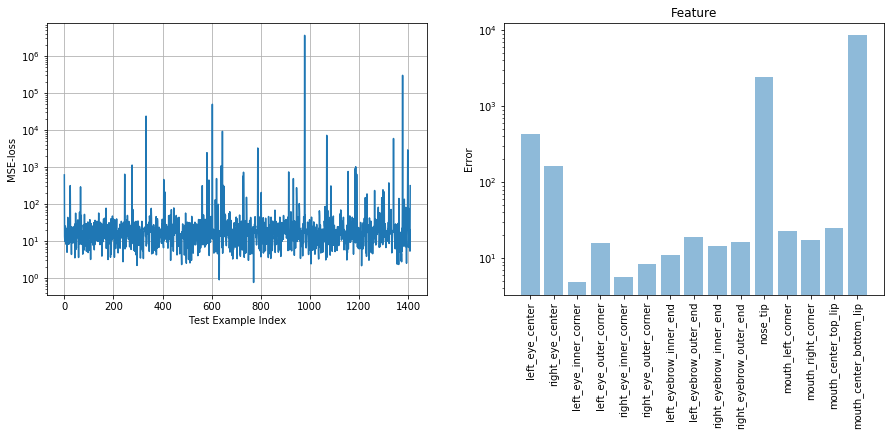

In [32]:
plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=.25)
plt.subplot(1,2,1)   
plt.grid()
plt.plot(sqe_df2['Mean_Error'])
plt.xlabel("Test Example Index")
plt.ylabel("MSE-loss")
plt.yscale("log")

plt.subplot(1,2,2) 
plt.subplots_adjust(hspace=.75)
y_pos = np.arange(len(sqe_by_feature2.index))
plt.bar(y_pos, sqe_by_feature2, align='center', alpha=0.5)
plt.xticks(y_pos, sqe_by_feature2.index)
plt.ylabel('Error')
plt.title('Feature')
plt.yscale("log")
plt.xticks(rotation=90)

Minimum Error Example: 771    0.750284
Name: Mean_Error, dtype: float64


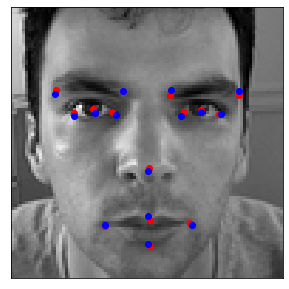

In [33]:
# Ploting Smallest Error Example
index =sqe_df2[['Mean_Error']].idxmin()
print('Minimum Error Example:',sqe_df2['Mean_Error'][index])

fig, (ax1) = plt.subplots(1,figsize=(5,5))
plot_prediction(x_all_test,y_all_test,y_test_pred_base_ext,index,ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
fig.show()

Maximum Error Example: 979    3.611586e+06
Name: Mean_Error, dtype: float64


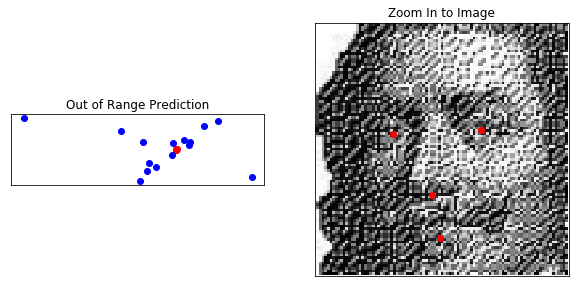

In [34]:
# Ploting largest Error Example
index =sqe_df2[['Mean_Error']].idxmax()
print('Maximum Error Example:',sqe_df2['Mean_Error'][index])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
plot_prediction(x_all_test,y_all_test,y_test_pred_base_ext,index,ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_title('Out of Range Prediction')

plot_prediction(x_all_test,y_all_test,y_test_pred_base_ext,index,ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim([0,96])
ax2.set_ylim([96,0])
ax2.set_title('Zoom In to Image')

fig.show()

## Mask Model

The previous two models have been trained with the examples that have all labels that represent a small part of the whole dataset. We included the Masked Model to overcome this issue. This model incorporates all available training dataset even when examples have only 1 label. The masked model is based on the  following research paper: We et. al. (2018), ***A Deep Residual convolutional neural network for facial keypoint detection with missing labels***. They solve the problem by adding a masked layer that zeros the output corresponding to missing labels that are filled by zeros previously. Our approach follows the same outcome but it is implemented differently. We do not create an extra layer in our model but force the output to be zero by including a custom loss function.    

### Data Transformation

This model requires transforming the labeled data to include the mask information. In the label data, each row has 30 elements that correspond to x and y pixel coordinates for all 15 keypoints features. As described above, many examples do not include all features. The transformation consists of 3 steps:
  1. Create an equivalent shape dataset with zero in the position of each missed coordinates and 1 everywhere else.
  2. Replace the missing values by zeros in the label data.
  3. Concatenate the label data and the masked data.

Now the transformed label data consist of 60 elements on each row. The first 30 that correspond to the pixels coordinates and the last 30 elements to the masked labels. Function ***mask_data*** creates the masked labels.   

In [35]:
# Masking data
# This function has two steps. First create a masked labels copy with 1 at nvalid values and 0 where the coordinates 
# are missing. The second step is a copy of the original data replacing by 0 the missing data to replace the

def mask_data(df):
    
    df_mask = df.copy()
    df_mask = df_mask.drop(['Image'],axis=1)
    
    df_labels_mask = df_mask.copy()
    
    return df_labels_mask.fillna(0.0).to_numpy(),df_mask.notnull().astype('float64').to_numpy()   

In [36]:
# Preparing the data for running the the masked model
y_dummy,x_all_train = data_prep(all_train_data_raw)
y_dummy,x_all_test = data_prep(all_test_data_raw)

#Mask Data
y_all_train_mask, mask_values_train = mask_data(all_train_data_raw)
y_all_test_mask, mask_values_test = mask_data(all_test_data_raw)

#Scaling Data
x_all_train = image_norm(x_all_train)
y_all_train_mask = label_norm(y_all_train_mask)*mask_values_train
x_all_test = image_norm(x_all_test)
y_all_test_mask = label_norm(y_all_test_mask)*mask_values_test

#Concatenate Labels and Mask labels
ty = tf.constant(y_all_train_mask) # Numpy to Tensor Flow
tm = tf.constant(mask_values_train) # Numpy to Tensor Flow
y_all_train_mask_concat = K.concatenate((ty,tm), axis=-1)

ty = tf.constant(y_all_test_mask) # Numpy to Tensor Flow
tm = tf.constant(mask_values_test) # Numpy to Tensor Flow
y_all_test_mask_concat = K.concatenate((ty,tm), axis=-1)

print('y_all_train_mask_concat shape: ' ,y_all_train_mask_concat.shape)
print('x_all_train shape: ', x_all_train.shape)
print('y_all_test_mask_concat shape: ' ,y_all_test_mask_concat.shape)
print('x_all_test shape: ', x_all_test.shape)

y_all_train_mask_concat shape:  (5640, 60)
x_all_train shape:  (5640, 96, 96, 1)
y_all_test_mask_concat shape:  (1410, 60)
x_all_test shape:  (1410, 96, 96, 1)


### Masked Loss Function

This function calculates the loss in the masked model. The masked part of the data multiplies the predictions forcing the loss to be zero. Therefore, the backpropagation does not account for these labels. 

In [37]:
def masked_loss(y_true, y_pred):
    squared_difference = tf.square(y_true[:,:30] - y_pred*y_true[:,30:])
    
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

### Model with Masked Loss Function

The masked model has the same architecture as the extended model described in the previous section. The only difference is that this model uses the custom loss function above (***masked_loss***).  

In [38]:
model_mask = Sequential()

model_mask.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model_mask.add(ReLU())
model_mask.add(MaxPool2D(pool_size=(2, 2)))
model_mask.add(BatchNormalization())

model_mask.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model_mask.add(ReLU())
model_mask.add(MaxPool2D(pool_size=(2, 2)))
model_mask.add(BatchNormalization())

model_mask.add(Convolution2D(128, (3,3), padding='same', use_bias=False))
model_mask.add(ReLU())
model_mask.add(MaxPool2D(pool_size=(2, 2)))
model_mask.add(BatchNormalization())

model_mask.add(Flatten())
model_mask.add(Dense(512,activation='relu'))
model_mask.add(Dropout(0.1))
model_mask.add(Dense(30))

model_mask.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
re_lu_5 (ReLU)               (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)       

### Masked Model Error Analysis

After fitting the model with the masked loss function using all of the training data, we evaluated the model's performance on our test data and noticed we experienced a significant improvement in our RMSE on the test data which dropped to 4. Per the MSE loss function chart below for the train and test/validation data, the model performs well on both the training and test datasets suggesting our model is not overfitting.  When we compare our errors by feature, we noticed considerable improvements on the eye centers, nose tips, and the mouth center bottom lip features. Moreover, when we compared our error on the image that had the worst predictions from previous models, we now were able to make predictions that were in range and the MSE dropped dramatically to 6.15 indicating our model was able to generalize to the test data better when we trained on all the full training set.  We did notice that our model did not perform well on face images that were very small.  We will explore ways to account for these types of images in the future improvements section of this notebook.

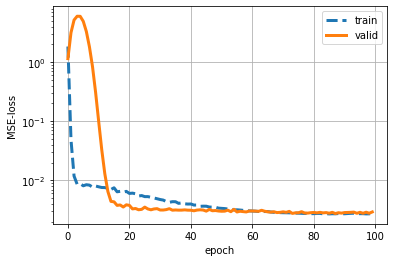

In [39]:
if fl.exists(filepath + '\\models\\model_mask'):
    # Loading the model and the loss
    model_mask_loss = json.load(open(filepath + '\\models\\model_mask_loss.json'))
    model_mask = keras.models.load_model(filepath + '\\models\\model_mask', compile=False, custom_objects={'loss': masked_loss}) 
    
    # Ploting Error Analysis
    plot_loss_json(model_mask_loss)
else:
    Batch = 128
    model_mask.compile(optimizer=Adam(lr=.001), loss=masked_loss)
    model_mask_loss = model_mask.fit(x_all_train,y_all_train_mask_concat, batch_size=Batch, 
                                      validation_data=(x_all_test,y_all_test_mask_concat), 
                                      epochs=100,verbose=1)
    model_mask.save(filepath + '\\models\\model_mask')
    loss_to_json(model_mask_loss,filepath + '\\models\\model_mask_loss.json')
    
    # Ploting Error Analysis
    plot_loss(model_mask_loss)

In [40]:
# Preparing all test examples
y_all_test,x_all_test = data_prep(all_test_data_raw)
x_all_test = image_norm(x_all_test)

#Prediction with model trained with all features
y_test_pred_mask = model_mask.predict(x_all_test)
y_test_pred_mask = label_norm_back(y_test_pred_mask)

# Calculating Error DataFrame by Feature for each Test Example
sqe_df3 = error_df(y_all_test,y_test_pred_mask)

# Mean Error per Feature
sqe_by_feature3 = sqe_df3.mean(axis=0)

# Mean Error per Example
sqe_df3['Mean_Error'] = sqe_df3.mean(axis=1)

# Train Error

# Preparing all test examples
y_all_train,x_all_train = data_prep(all_train_data_raw)
x_all_train = image_norm(x_all_train)

#Prediction with model trained with all features
y_train_pred_mask = model_mask.predict(x_all_train)
y_train_pred_mask = label_norm_back(y_train_pred_mask)

# Calculating Error DataFrame by Feature for each Test Example
sqe_df3t = error_df(y_all_train,y_train_pred_mask)

# Mean Error per Example
sqe_df3t['Mean_Error'] = sqe_df3t.mean(axis=1)

test_error = np.sqrt(sqe_df3['Mean_Error'].mean())
train_error = np.sqrt(sqe_df3t['Mean_Error'].mean())

print('Base Masked Model - RMSE')
print('{:<8} {:<8}'.format('Train', 'Test'))
print('{:<8.2f} {:<8.2f}'.format(train_error,test_error))

Base Masked Model - RMSE
Train    Test    
3.59     4.06    


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

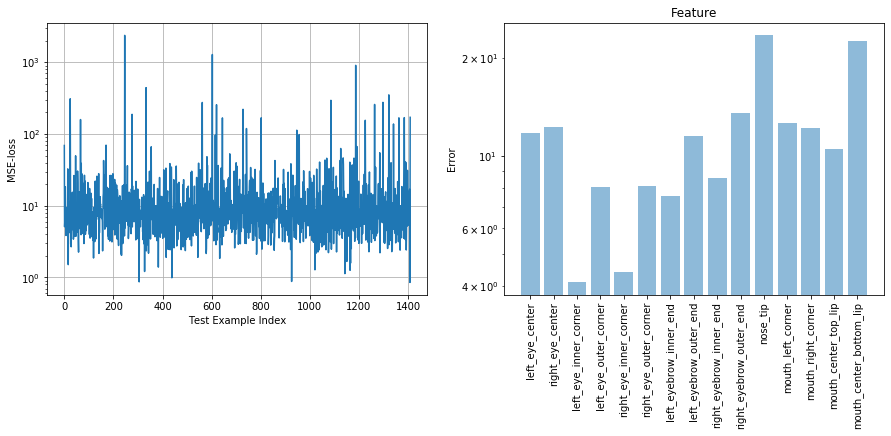

In [41]:
plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=.25)
plt.subplot(1,2,1)   
plt.grid()
plt.plot(sqe_df3['Mean_Error'])
plt.xlabel("Test Example Index")
plt.ylabel("MSE-loss")
plt.yscale("log")

plt.subplot(1,2,2) 
plt.subplots_adjust(hspace=.75)
y_pos = np.arange(len(sqe_by_feature3.index))
plt.bar(y_pos, sqe_by_feature3, align='center', alpha=0.5)
plt.xticks(y_pos, sqe_by_feature3.index)
plt.ylabel('Error')
plt.title('Feature')
plt.yscale("log")
plt.xticks(rotation=90)

Minimum Error Example: 1408    0.852833
Name: Mean_Error, dtype: float64


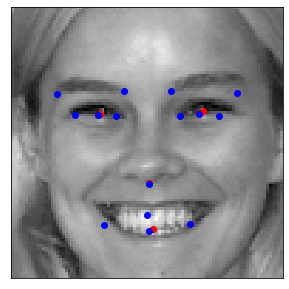

In [42]:
# Ploting Smallest Error Example
index =sqe_df3[['Mean_Error']].idxmin()
print('Minimum Error Example:',sqe_df3['Mean_Error'][index])


fig, (ax1) = plt.subplots(1,figsize=(5,5))
plot_prediction(x_all_test,y_all_test,y_test_pred_mask,index,ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)

fig.show()

Maximum Error Example: 246    2378.880651
Name: Mean_Error, dtype: float64


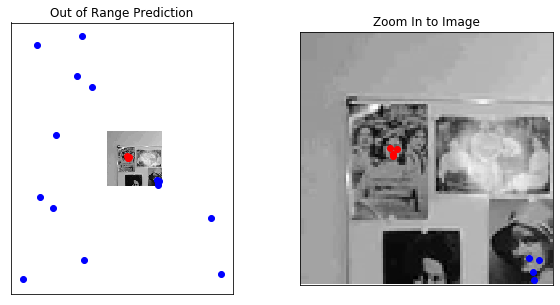

In [43]:
# Ploting Largest Error Example
index =sqe_df3[['Mean_Error']].idxmax()
print('Maximum Error Example:',sqe_df3['Mean_Error'][index])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
plot_prediction(x_all_test,y_all_test,y_test_pred_mask,index,ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_title('Out of Range Prediction')

plot_prediction(x_all_test,y_all_test,y_test_pred_mask,index,ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim([0,96])
ax2.set_ylim([96,0])
ax2.set_title('Zoom In to Image')

fig.show()

Maximum Error Example: 6.153603485490368


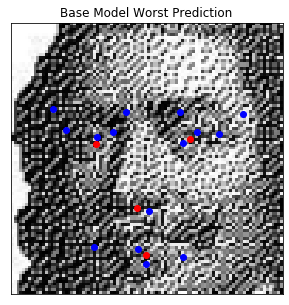

In [44]:
# Ploting Largest Prediction from Previous Models
index = 979
print('Maximum Error Example:',sqe_df3['Mean_Error'][index])
fig, (ax1) = plt.subplots(1,figsize=(5,5))
plot_prediction(x_all_test,y_all_test,y_test_pred_mask,index,ax1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.grid(False)
ax1.set_title('Base Model Worst Prediction')
fig.show()

## Model Comparison

We showed two improvements from the base model. First, we added two layers and increased the number of nodes at each of those layers. Second, we masked the loss function so the unlabeled features in the image do not contribute for weight updates. This last modification allowed us to include all training examples instead of using only examples of the training data that have all 15 features labeled. Here we show the loss from training data and test (validation data).




Model               RMSE
Base              258.34
Base Extended      53.64
Masked              4.06


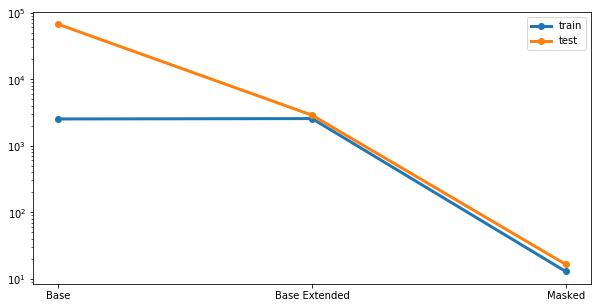

In [45]:
test_error = [sqe_df['Mean_Error'].mean(),sqe_df2['Mean_Error'].mean(),sqe_df3['Mean_Error'].mean()]
train_error = [sqe_dft['Mean_Error'].mean(),sqe_df2t['Mean_Error'].mean(),sqe_df3t['Mean_Error'].mean()]
model = ['Base', 'Base Extended', 'Masked']

test_rmse = np.sqrt(np.array(test_error))
train_rmse = np.sqrt(np.array(train_error))

print('{:<15} {:>8}'.format('Model', 'RMSE'))
for i in range(3):
    print('{:<15} {:8.2f}'.format(model[i],test_rmse[i]))

plt.figure(figsize=(10,5))
plt.plot(model,train_error,'o-',linewidth=3, label="train")
plt.plot(model,test_error,'o-',linewidth=3, label="test")
plt.yscale("log")
plt.legend()
plt.show()

## Future Improvements





### Face Size and Location

When building future models, we would like to explore additional techniques to account for some images not having certain features as well as to make better predictions when the size of the face is small.  One of the challenges when identifying keypoints features in an image is to detect whether the feature is present in the image. For instance, a profile picture probably does not have one of the eyes in the image so no label is required. However, the current architecture of the network in this project is designed to estimate a location of the given feature even outside of the picture range.

Another challenge we encountered in this project is making predictions when the size of the face very small and zoomed out. We explore identifying those examples that are zoomed out or not centered in the image. We estimated the size of the face by calculating by the average distance between eye's centers and distance between nose tip and each eye. We also calculated the average location of the all present features in each example.  These distance metrics could be included as an additional input into the CNN to help train the model to identify smaller face images.


In [46]:
# Preparing the data
y_all_data, x_all_data = data_prep(all_data_raw)

# All Features Average
xmeans = np.nanmean(y_all_data[:,0:30:2], axis = 1)
ymeans = np.nanmean(y_all_data[:,1:31:2], axis = 1)

# Number of Features 
nfeat = np.sum(~np.isnan(y_all_data[:,0:31:1]),axis = 1)/2

# Calculating the average distance Right Eye Center- Left Eye Center - Nose Tip
def p_dist(labels):
    dist = np.zeros([labels.shape[0],3])
    dist[:,0] = np.sqrt((labels[:,0] - labels[:,2])**2 + (labels[:,1] - labels[:,3])**2)
    dist[:,1] = np.sqrt((labels[:,0] - labels[:,20])**2 + (labels[:,1] - labels[:,21])**2)
    dist[:,2] = np.sqrt((labels[:,2] - labels[:,20])**2 + (labels[:,3] - labels[:,21])**2)
    
    return np.nanmean(dist, axis = 1)

distance = p_dist(y_all_data)

#### Histogram

The histogram shows the number of examples by the proportion of the face in the image. Note that there are relatively few examples which the average features distance is less than 20 pixels. 

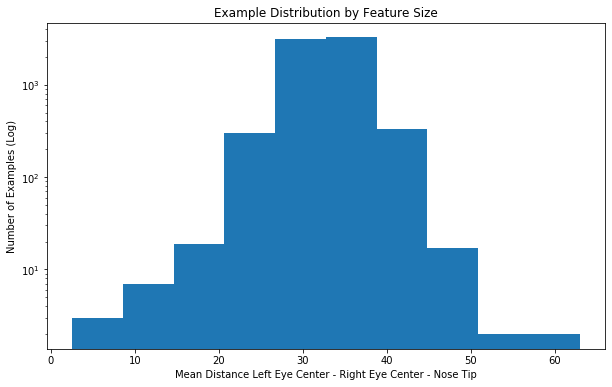

In [47]:
# Histogram on Average Distance 
plt.figure(figsize=(10,6))
plt.hist(distance)
plt.yscale("log")
plt.xlabel("Mean Distance Left Eye Center - Right Eye Center - Nose Tip")
plt.ylabel("Number of Examples (Log)")
plt.title('Example Distribution by Feature Size')
plt.show()

#### Scatter Visualization 

The scatter visualization shows the average location, the average distance between features and the number of features present in each example. 

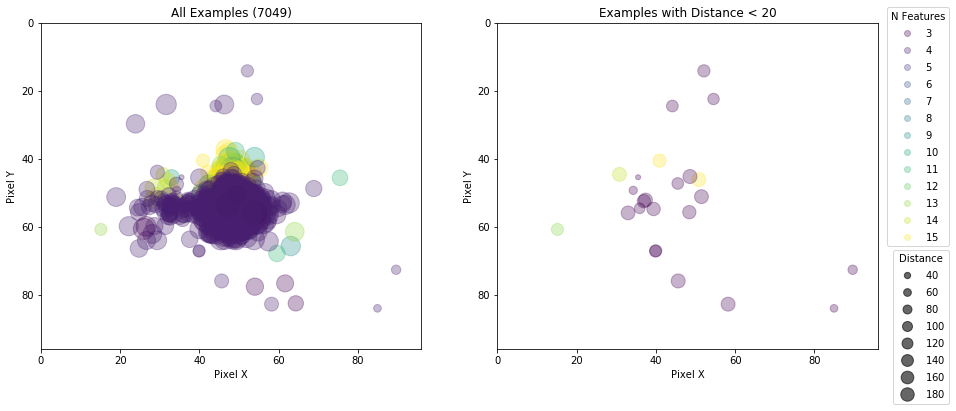

In [48]:
# Scatter with All Example

fig, ax = plt.subplots(1,2, figsize=(15,6))

scatter1 = ax[0].scatter(xmeans, ymeans, s=10*distance, alpha=0.3, c=nfeat, label=nfeat)

ax[0].set_xlim([0,96])
ax[0].set_ylim([0,96])
ax[0].invert_yaxis()
ax[0].set_xlabel("Pixel X")
ax[0].set_ylabel("Pixel Y")
ax[0].set_title('All Examples (7049)')

scatter2 = ax[1].scatter(xmeans[distance < 20], ymeans[distance < 20], s=10*distance[distance < 20], alpha=0.3, 
            c=nfeat[distance < 20])

ax[1].set_xlim([0,96])
ax[1].set_ylim([0,96])
ax[1].invert_yaxis()
ax[1].set_xlabel("Pixel X")
ax[1].set_ylabel("Pixel Y")
ax[1].set_title('Examples with Distance < 20')


legend1 = ax[1].legend(*scatter1.legend_elements(),
                    loc="lower right", title="N Features",bbox_to_anchor=(1.2, 0.3))

ax[1].add_artist(legend1)

handles, labels = scatter2.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax[1].legend(handles, labels, loc="upper right", title="Distance",bbox_to_anchor=(1.2, 0.32))
plt.show()

#### Images and Distance

In this section we show 3 different examples with the lowest calculated feature distance, nearly mean distance and the largest diststance. We noticed that the low values probably correspond to small faces (zoomed out) pictures and the large distances correspond to misslabeled images. 

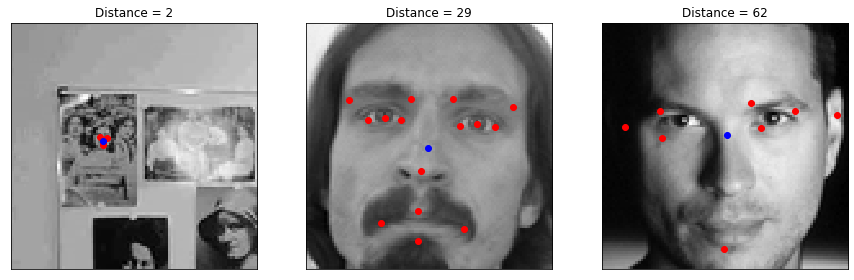

In [49]:
# Zoomed in Example
index = np.nanargmin(distance)
plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=.5)
plt.subplot(1,3,1)   
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x_all_data[index].reshape(96,96),interpolation='nearest', cmap='gray')
for i in range(0,y_all_data.shape[1],2):
    plt.scatter(y_all_data[index,i], y_all_data[index,i+1], c='r')  
plt.scatter(xmeans[index],ymeans[index], c='b')
plt.title('Distance = ' + str(int(distance[index])))

# Zoomed out Example
sz = 18
index = np.nanargmax(distance)
plt.subplots_adjust(hspace=.5)
plt.subplot(1,3,3)   
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x_all_data[index].reshape(96,96),interpolation='nearest', cmap='gray')
for i in range(0,y_all_data.shape[1],2):
    plt.scatter(y_all_data[index,i], y_all_data[index,i+1], c='r')
plt.scatter(xmeans[index],ymeans[index], c='b')  
plt.title('Distance = ' + str(int(distance[index])))

# Zoomed out Example
index = 0
plt.subplots_adjust(hspace=.5)
plt.subplot(1,3,2)   
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x_all_data[index].reshape(96,96),interpolation='nearest', cmap='gray')
for i in range(0,y_all_data.shape[1],2):
    plt.scatter(y_all_data[index,i], y_all_data[index,i+1], c='r')  
plt.scatter(xmeans[index],ymeans[index], c='b')  
plt.title('Distance = ' + str(int(distance[index])))

plt.show()

### Data Augmentation

In addition to adding information about the size of face and location into the model, we could also augment our existing training dataset to increase the size of the overall training dataset.  For example, as shown in the histogram above there are several photos that have a small distance eye centers, which could signal the size of the face is very small on the image.  To provide more training images with small faces, we could explore zooming out of the full size images and adjusting the coordinates of the features accordingly.  We could also flip images to increase the number of images when a person is not looking directly at the camera.  We believe this additional training data could improve the predictions of future models.   

### Feature Detection

An additional network can be built to identify whether the features are in the image. Then, in the currently implemented network, those features would be masked. This convolutional network would extract partial images centered on the labeled features that would be the train data. The labels would correspond to the name of the features. This would be a classification network. The example below shows the extraction of the images corresponding to features.

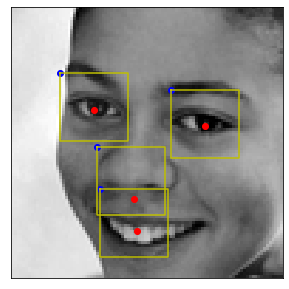

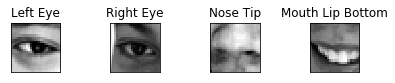

In [50]:
# Zoomed out Example
sz = 24
index = 4587
plt.figure(figsize=(5,5))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(x_all_data[index].reshape(96,96),interpolation='nearest', cmap='gray')
xx = []
yy = []
for i in [0,2,20,28]:
    plt.scatter(y_all_data[index,i], y_all_data[index,i+1], c='r')
    xo = int(y_all_data[index,i] - sz*0.5)
    if i == 0 or i == 2:
        yo = int(y_all_data[index,i+1] - sz*0.5)
    elif i == 20:
        yo = int(y_all_data[index,i+1] - sz*0.75)
    else:
        yo = int(y_all_data[index,i+1] - sz*0.60)
    sq= np.array([(xo,yo),(xo+sz,yo),(xo+sz,yo+sz),(xo,yo+sz),(xo,yo)])
    plt.scatter(xo,yo, c='b')
    plt.plot(sq[:,0],sq[:,1],'y')
    xx.append(xo)
    yy.append(yo)

image1 = x_all_data[index].copy()
image1 = image1.reshape(96,96)
plt.figure()
labels = ['Left Eye', 'Right Eye', 'Nose Tip', 'Mouth Lip Bottom']
for i in range(len(xx)):
    simg = image1[yy[i]:yy[i]+sz,xx[i]:xx[i]+sz]
    plt.subplot(1,4,i+1)

    plt.imshow(simg,interpolation='nearest', cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i])
    plt.grid(False)
    plt.tight_layout(pad=3.0)

## Conclusions



* Our Convolutional Neural Network successfully detected 15 facial keypoints with an RMSE of 4.06.
*  The masked loss function reduced the RMSE of the model from 53.64 to 4.06 not only because it considers the missing labels but because it also allows us to increase the amount of training data we could use to fit our model.
*  Zoomed out and low quality images remain challenging for the implemented network, and we recommend exploring feature engineering focused on capturing the size of the face in the image, training dataset augmentation (flipping and zooming out images), and detecting whether certain features exist to improve the performance of future models.


Additional References

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab

https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial

http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

